# CS216 : Assignment 1

Please edit the cell below to include your name and student ID #


---

**Brooke Ryan**

**51809437**

---

# 0. Python & Jupyter Notebook Tutorials 

We will make extensive use of Python's numerical arrays (NumPy) and interactive plotting (Matplotlib) 
in Jupyter notebooks for the course assignments. This first assignment is intended as a gentle warm 
up in case you haven't used these tools before. If you haven't used Jupyter before I'd suggest you
start by reading through the following tutorials:

https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#starting-the-notebook-server
https://nbviewer.jupyter.org/github/jupyter/notebook/blob/master/docs/source/examples/Notebook/Notebook%20Basics.ipynb
https://nbviewer.jupyter.org/github/jupyter/notebook/blob/master/docs/source/examples/Notebook/Running%20Code.ipynb

If you need a refresher on Python, this is a concise tutorial:

http://cs231n.github.io/python-numpy-tutorial/

This page gives a good introduction to NumPy and many examples of using NumPy along with Matplotlib:

http://scipy-lectures.org/intro/numpy/array_object.html

You should also get comfortable with searching through the documentation as needed

https://numpy.org/doc/stable/reference/index.html

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html



In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


# for problem 1
import os
from PIL import Image
import imghdr
import random


# for problem 2
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix

# for problem 3
from scipy.ndimage import gaussian_filter
from scipy.ndimage import zoom

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Image Manipulation  

In this exercise you will write code which loads a collection of images (which are all the same size), computes a pixelwise average of the images, and displays the resulting average.  You can see some interesting related discussion here http://people.csail.mit.edu/torralba/gallery/ and here http://www.salavon.com/work/SpecialMoments/
***
Download the images provided on the Canvas course website for this assignment `averageimage_data.zip`. There are two sets, `set1` and `set2`. Notice that they are not necessarily all the same size within a single set.

***

### 1.1 Implementation [18pts]

Write a function in the cell below that loads in one of the sets of images and computes their average. You can use the **os.listdir** to get the list of files in the directory. As you load in the images, you should compute an average image on the fly. Color images are represented by a 3-dimensional array of size (HxWx3) where the third dimension indexes the red, green and blue channels. Since the images are not the same size, you will first need to resize each image to a fixed size (e.g. something like 300x215). You can set the height and width to be size of the first image you load, or if you want to be a bit more clever, make it the average dimensions of the images in the directory.

You should encapsulate your code in a function called **average_image** that takes the image directory as an input and returns the average of the images in that directory. Your function should implement some error checking. Specifically your function should skip over any files in the directory that are not images (**plt.imread** will thrown an **OSError** if the file is not an image). It should also ignore images that are not color images. 

NOTE: In general for this course we will think of images as containing floating point values. In practice, when stored in files they are typically quantized and stored as uint8 values. When you load in an image it is usually a good idea to just convert it to a float in the range [0,1] to avoid potential bugs later when you try to do mathematical operations of the pixel values. You can use some code like:
```python
if (I.dtype == np.uint8):
   I = I.astype(float) / 256.
```
to carry this out.

In [6]:
def average_image(dirname):
    """
    Computes the average of all color images in a specified directory and returns the result.
    
    Parameters
    ----------
    dirname : str
        Directory to search for images

        
    Returns
    -------
    numpy.array (dtype=float)
        HxWx3 array containing the average of the images found
        
    """

    num_images = 0

    for file in os.listdir(dirname):
        filename = os.path.join(dirname, file)

        # Only continues if the file is an image
        if imghdr.what(filename):

            # Load an image from a file into a numpy array
            image = plt.imread(dirname + file)

            # Only continues if image is RGB
            if len(image.shape) == 3 and image.shape[2] == 3:

                num_images += 1

                # Gets the dimensions of the first image in the directory + sets as default
                if num_images == 1:
                    default_shape = image.shape
                    sum_images = np.zeros(default_shape, np.float)

                # Convert image to float in range [0, 1] to avoid potential bugs
                if image.dtype == np.uint8:
                    image = image.astype(float) / 256.

                # Resize image to default shape
                image = np.resize(image, default_shape)

                # Total sum of image values thus far
                sum_images = sum_images + image

                # Current average image
                average = sum_images/ num_images

    return average

In [7]:
#
## some useful functions for this part
#
## load an image from a file into a numpy array
#
# I = plt.imread(...)
#
## looping over files in a directory
#
#  for file in os.listdir(dirname):
#       filename = os.path.join(dirname,file)
#       if os.path.isfile(filename):
#           try:
#               ...
#            except OSError as err:
#               ...
#               continue

***

### 1.2 Visualization [7pts]

Write code below which calls your **average_image()** function twice, once for each set of images. Display the resulting average images. Also display a single example image from each set for comparison.  Discuss briefly what you see. In what ways does the average differ from the individual examples?

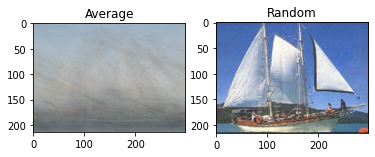

In [8]:
set1 = '/content/drive/MyDrive/ImageUnderstanding/averageimage_data/set1/'
avg = average_image(set1)
rd = plt.imread(set1 + random.choice(os.listdir(set1)))

fig, axs = plt.subplots(1, 2)
axs[0].set_title("Average")
axs[0].imshow(avg)
axs[1].set_title("Random")
axs[1].imshow(rd)

plt.show()

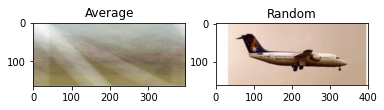

In [9]:
set2 = '/content/drive/MyDrive/ImageUnderstanding/averageimage_data/set2/'
avg = average_image(set2)
rd = plt.imread(set2 + random.choice(os.listdir(set2)))

fig, axs = plt.subplots(1, 2)
axs[0].set_title("Average")
axs[0].imshow(avg)
axs[1].set_title("Random")
axs[1].imshow(rd)

plt.show()

The averages of the images are significantly blurrier than the individual photographs taken randomly from the corresponding dataset.  However, the outline of the category of images, for instance the outline of the sailboat can faintly be seen for the first example.  

# 2. Image Classification

![cifar-10.png](attachment:cifar-10.png)

In this problem you will write code that will classify small 32x32 color images into one of 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck). You should implement your functions "from scratch" (i.e. don't use other libraries beyond the ones we've already imported).

You will images from here: [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html), using the link for the Python CIFAR-10 dataset. Please refer to the webpage for the description of the dataset format. I suggest you first debug your code on a subset of the training and testing data, and then run it on all the data. If you are running into memory or computational issues, it is fine to use a subset of the data, but please make note of this in your writeup.


### 2.1 Load in the data 
To make sure that you understand the data format, write code to display the first airplane in the test set.

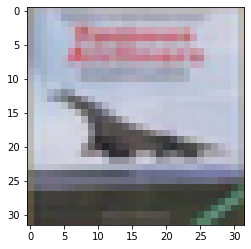

In [10]:
cifar = "/content/drive/MyDrive/ImageUnderstanding/cifar-10-batches-py/"

# Code from https://stackoverflow.com/questions/33137741/fastest-way-to-convert-a-dicts-keys-values-from-bytes-to-str-in-python3
def convert(data):
    if isinstance(data, bytes):  return data.decode()
    if isinstance(data, dict):   return dict(map(convert, data.items()))
    if isinstance(data, tuple):  return tuple(map(convert, data))
    if isinstance(data, list):   return list(map(convert, data))
    return data

# Code from https://gist.github.com/fzliu/64821d31816bce595a4bbd98588b37f5
def save_as_image(img_flat, fname):
    from skimage.io import imsave
    """
        Saves a data blob as an image file.
    """

    # consecutive 1024 entries store color channels of 32x32 image
    img_R = img_flat[0:1024].reshape((32, 32))
    img_G = img_flat[1024:2048].reshape((32, 32))
    img_B = img_flat[2048:3072].reshape((32, 32))
    img = np.dstack((img_R, img_G, img_B))

    # Convert image to float in range [0, 1] to avoid potential bugs
    if img.dtype == np.uint8:
        img = img.astype(float) / 256.

    return img
    # imsave(os.path.join(PIXELS_DIR, fname), img)

# Code from https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return convert(dict)

test_batch = unpickle(cifar + 'test_batch')
batches_meta = unpickle(cifar + 'batches.meta')

# Index of airplane, since airplane label is 0
first_airplane_index = test_batch['labels'].index(0)

img_flat = test_batch["data"][first_airplane_index]
fname = test_batch["filenames"][first_airplane_index]
label = test_batch["labels"][first_airplane_index]

img = save_as_image(img_flat, fname)

plt.imshow(img)

### 2.2 Nearest Neighbor [15pts]
Write a function that uses nearest-neighbor (NN) classification to predicts a label for a test image by returning the label of which ever training images is closest (measured using the Euclidean distance between the vector of pixel values).  You can use the SciPy function ***scipy.spatial.distance.cdist*** to efficiently compute the pairwise distances between the test examples and all training examples.


In [24]:
class NearestNeighbors(object):
    # Nearest neighbor classifier
    def __init__(self, m):
        self.method = m

    def train(self, X, y):
        # Learn the training instances
        self.X_train = X
        self.y_train = y

    def predict(self, X_te, Y_te):
      y_pred = np.empty_like(Y_te)
      distances = cdist(X_te, self.X_train, metric=self.method)
      for i in range(X_te.shape[0]):
        min_index = distances[i].argmin()
        y_pred[i] = self.y_train[min_index]
      return y_pred

# Helper function from https://github.com/dhingratul/k-Nearest-Neighbors/blob/master/kNN.py
def process_data(direc, filename, batches):
    """
    Converts the data in batches to a full training set
    """
    for j in range(1, batches+1):
        file = direc + filename + str(j)
        dic = unpickle(file)
        if j == 1:
            X_train = dic['data']
            y_train = dic['labels']
        else:
            temp_X = dic['data']
            temp_y = dic['labels']
            X_train = np.concatenate((X_train, temp_X))
            y_train = np.concatenate((y_train, temp_y))
    return X_train, y_train

def nn_classify(dirname, test_images_dir, filename, batches, method="euclidean"):
    """
    Given a set of training images with a label for each image and 
    set of test images, this function performs nearest-neighbor 
    classification and returns a set of labels for the test images.
    
    Parameters
    ----------
    training_images: str
        String path to set of training images.
    test_images: str
        String path to set of test images.
    method: str
        Method used to calculate nearest neighbor.

    Returns
    -------
    labels : set
        A set, containing the labels for the test images.
    """
    X_train, Y_train = process_data(dirname, filename, batches)
    test_data = unpickle(dirname + test_images_dir)
    X_test = test_data['data']
    global Y_test
    Y_test = test_data['labels']

    nn = NearestNeighbors(method)
    nn.train(X_train, Y_train)
    Yte_predict = nn.predict(X_test, Y_test)
    return Yte_predict

Yte_predict = nn_classify('/content/drive/MyDrive/ImageUnderstanding/cifar-10-batches-py/',
                          'test_batch',
                          'data_batch_',
                          batches=1)
print("Yte_predict")
print(Yte_predict)


Yte_predict
[6 8 8 ... 6 6 0]


### 2.3 Evaluation Metrics [10pts]
Write a function to compute a class confusion matrix. The confusion matrix will be an array where entry (i,j) is the fraction of times an image of class 'i' was predicted to be class 'j'. The rows of the matrix should sum to 1. Display this matrix as an image using ***imshow(cm, interpolation='nearest', cmap=cmap)*** with an appropriate colormap. You should also display a ***colorbar*** to help interpreting the values. Finally, print out the average classification accuracy across all classes (the average of the diagonal values in this matrix). 

In [25]:
def evaluate(true_labels,predicted_labels):
    """
    Given a set of ground-truth labels, a set of predicted labels 
    and the number of classes (i.e. NumPy arrays with integers in [0,..,k-1])
    compute and display the class confusion matrix and the average 
    classification accuracy.
    
    Parameters
    ----------
    true_labels: np array
    predicted_labels: np array
        
    Returns
    -------
    confusion_matrix, accuracies
    
        
    """
    matrix = confusion_matrix(Y_test, Yte_predict)
    accuracies = matrix.diagonal()/matrix.sum(axis=1)

    return matrix, accuracies

evaluate(Y_test, Yte_predict)

(array([[413,  12, 154,  27,  75,  21,  32,  14, 239,  13],
        [121, 157, 103,  59, 145,  49, 110,  21, 204,  31],
        [ 99,   5, 345,  64, 245,  45, 109,  21,  62,   5],
        [ 61,   8, 197, 148, 182, 119, 173,  39,  58,  15],
        [ 62,   4, 248,  55, 396,  40, 119,  22,  51,   3],
        [ 65,   6, 170, 139, 173, 203, 134,  33,  67,  10],
        [ 26,   4, 225,  89, 241,  63, 298,  12,  37,   5],
        [ 77,   5, 157,  68, 228,  76,  91, 207,  79,  12],
        [149,  32,  65,  29,  49,  30,  48,  15, 565,  18],
        [127,  52,  97,  53, 131,  46,  79,  38, 232, 145]]),
 array([0.413, 0.157, 0.345, 0.148, 0.396, 0.203, 0.298, 0.207, 0.565,
        0.145]))

### 2.4 Experimentation [10pts]

Experiment with several different choices of distances besides Euclidian distance (e.g., cosine, correlation). You can do this by passing different options to ***cdist*** when computing the distance.  For each one you try, display the class confusion and average accuracy. To implement this in a clean way, you may want to modify your **nn_classify** function to take the metric as a parameter.


In [ ]:
metrics = {"cosine", "correlation", "euclidean"}

for i, metric in enumerate(metrics): 
  Yte_predict = nn_classify('/content/drive/MyDrive/ImageUnderstanding/cifar-10-batches-py/',
                            'test_batch',
                            'data_batch_',
                            batches=1,
                            method=metric)
  print("--------------------")
  print(metric)
  print("--------------------\n")
  matrix, accuracies = evaluate(Y_test, Yte_predict)
  print("~~~~~~~~~~~~~~~~")
  print("Confusion Matrix")
  print("~~~~~~~~~~~~~~~~")
  print(matrix)
  print("~~~~~~~~~~~~~~~~")
  print("Accuracies")
  print("~~~~~~~~~~~~~~~~")
  print(accuracies)


### 2.5 Discussion [5pts]

Which metric performs the best? Provide some explanation as to why you think this is the case. What classes are most commonly confused? Display a few examples of pairs of images from commonly confused classes and explain why the confusion might occur.

# 3. Hybrid Images 

![drangry.jpg](attachment:drangry.jpg)

The goal of this problem is to write an image filtering function and use it to create [hybrid images](https://en.wikipedia.org/wiki/Hybrid_image) using a simple version of the technique described in this [SIGGRAPH 2006 paper by Oliva, Torralba, and Schyns](https://dl.acm.org/doi/10.1145/1141911.1141919). Hybrid images are static images that change in interpretation as a function of the viewing distance. The basic idea is that high frequency tends to dominate perception when it is available, but, at a distance, only the low frequency (smooth) part of the signal can be seen. By blending the high frequency portion of one image with the low-frequency portion of another, you get a hybrid image that leads to different interpretations at different viewing distances.


### 3.1 Image Filtering [15pts]
Implement a function that takes a color image as input and splits it into a low-frequency component and a high-frequency component. To get the low-frequency component, you can blur the image using a Gaussian filter using ***scipy.ndimage.gaussian_filter*** where the **sigma** parameter of the Gaussian controls the amount of blur. To get the high-frequency component, you can simply take the original image and subtract out the low-frequency component.

In [ ]:
def split_bands(image,sigma):
    """
    Given an image, split the image into two frequency bands
    and return the two components (low,high)
    
    Parameters
    ----------
    image : numpy.array (dtype=float)
        a tuple of two HxWx3 arrays containing low/high freq components respectively

    sigma : float
        the width of the gaussian filter
        
    Returns
    -------
    tuple of numpy.array (dtype=float)
        two HxWx3 arrays containing low/high freq components respectively
          
    """

 

### 3.2 Visualization [5pts]

Experiment with your ***split_bands*** function on an image of your choosing which contains a mix of content. Display the high and low frequency component for several different settings of **sigma**. Make sure and experiment to find what values of **sigma** are "too large" or "too small" to be useful and then select a few intermediate values that span this range.

You will encounter a challenge here which is that while the low-frequency image will contain all values in the range [0,1], the high-frequency band image in general will contain negative values which **matplotlib** will not be able to display.  For visualization purposes, you can compute an offset value and scale in order to map the values back to [0,1]. 

In [ ]:
# code to visualize

### 3.3 Analysis [10pts]

What is the relation between the value of **sigma** and the content of your high and low-pass images? Ideally you should be able to come up with a formula for the frequency (measured in units of cycles-per-pixel) at which the Gaussian filter with a given **sigma** (measured in units of pixels) reduces the amplitude by 0.5. This is sometimes known as the crossover point between your low-pass and high-pass filter.

If you can't figure out how to determine this analytically, you are welcome to determine it experimentally by synthesizing images whose brightness is a **sin** function with a specific frequency, e.g.
```
x = (2*np.pi/25)*np.arange(100)
I = np.sin(x+x.reshape(100,1))   % 100x100 image with sinusoidal brightness
```
and then empirically determining the value of sigma you need to choose in order to have your low- and high-pass outputs have equal amplitudes. 

 ....your answer/explanation/experiment here...

### 3.4 Hybrid Image Generation [5pts]
Choose two images for which you would like to make a hybrid. The images should be fairly closely related (e.g., two different faces, a cat and dog face, two different words of text etc.).  You will also need to adjust the images so that they are the same size and are well aligned (e.g., for faces the eyes should be at the same location). You can do this in code or in a photo editing tool.

You can then run your ***split_bands*** function on both images. Finally produce your two hybrid images by adding the low-frequency content of one image with the high-frequency of the other.  Make sure and display your two input images and the two resulting hybrid images in your notebook. As before, you may need to offset the result to keep all the values positive.

As suggested by Figure 5 in the Oliva et. al. paper, you may be able to get better results by actually running your split bands function with two different sigmas in order to insert a larger gap between the high and low frequency bands. Feel free to experiment to get a good result.
